In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
smart_meters_in_london_path = kagglehub.dataset_download('jeanmidev/smart-meters-in-london')

print('Data source import complete.')


100%|██████████| 1.17G/1.17G [00:45<00:00, 27.3MB/s]

Extracting files...


Data source import complete.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Energy Consumption
To better follow the energy consumption, the government wants energy suppliers to install smart meters in every home in England, Wales and Scotland. There are more than 26 million homes for the energy suppliers to get to, with the goal of every home having a smart meter by 2020.

This roll out of meter is lead by the European Union who asked all member governments to look at smart meters as part of measures to upgrade our energy supply and tackle climate change. After an initial study, the British government decided to adopt smart meters as part of their plan to update our ageing energy system.

In this dataset, you will find a refactorised version of the data from the London data store, that contains the energy consumption readings for a sample of 5,567 London Households that took part in the UK Power Networks led Low Carbon London project between November 2011 and February 2014. The data from the smart meters seems associated only to the electrical consumption.

**Approach : **

1.  Combine all blocks into a single dataframe- keeping on relevant columns.
2. Use day-level energy consumption data per household to normalize data for inconsistent household count
3. Explore relationships between weather conditions and energy consumptions. Create clusters for the weather data- using which we can add weather identifiers to day-level data
4. Add UK holidays data to the day level data as an indicator.
5. Fit an ARIMA model
        i) ACF, PACF
        ii) Explore Seasonal Decomposition
        iii) Modelling
7. Fit an LSTM model

# Daily Energy Data Preparation

**Importing Libraries **

In [2]:
!pip install pmdarima
!pip install pyflux

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import os

from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

#from pyramid.arima import auto_arima
#from pmdarima.arima import auto_arima
#import pyflux as pf
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


### Energy Data

> We are predicting for energy demand in the future- therefore we are taking only energy sum i.e. total energy use per day for a given household.

In [4]:
# Combining all blocks
for num in range(0,112):
    df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project Energy/Input/daily_dataset/daily_dataset/block_"+str(num)+".csv")
    df = df[['day','LCLid','energy_sum']]
    df.reset_index()
    df.to_csv("hc_"+str(num)+".csv")

fout= open("energy.csv","a")
# first file:
for line in open("hc_0.csv"):
    fout.write(line)
# now the rest:
for num in range(0,112):
    f = open("hc_"+str(num)+".csv")
    f.readline() # skip the header
    for line in f:
         fout.write(line)
    f.close()
fout.close()

** Energy at Day Level **

In [5]:
energy = pd.read_csv('energy.csv')
len(energy)

3536007

**House Count**
> In the dataset we see that the number of households for which energy data was collected across different days are different. This is probably due to the gradually increasing adoption of smart meters in London.  This could lead to false interpretation that the energy for a particular day might be high when it could be that the data was only collected for more number of houses. We will look at the house count for each day.  

In [6]:
housecount = energy.groupby('day')[['LCLid']].nunique()
housecount.head(4)

,LCLid
day,
2011-11-23,13
2011-11-24,25
2011-11-25,32
2011-11-26,41


<Axes: xlabel='day'>

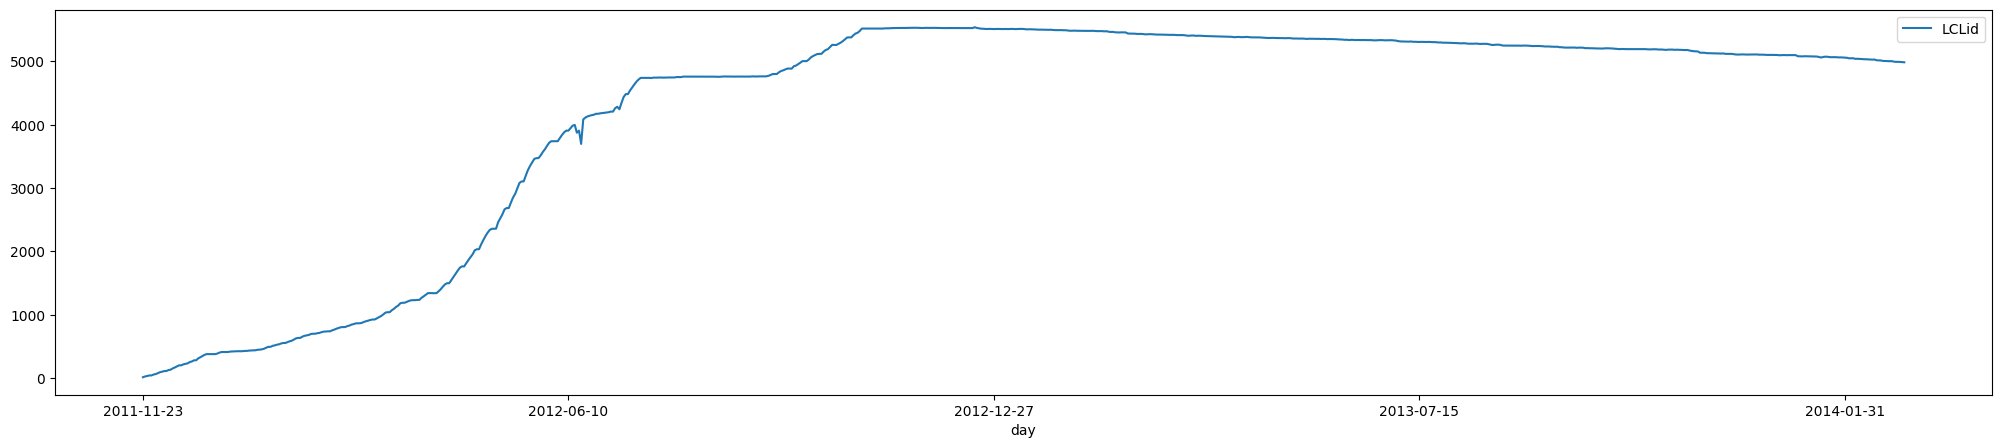

In [7]:
housecount.plot(figsize=(25,5))

**Normalization across households**
> The data collection across households are inconsistent- therefore we will be using *energy per household* as the target to predict rather than energy alone. This is an optional step as we can also predict for energy sum as whole for each household. However there are quite a lot of unique households for which we have to repeat the exercise and our ultimate goal is to predict overall consumption forecast and not at household level.  
This also means that since household level is removed, we are not looking into the ACORN details which is available at household level

In [8]:
energy = energy.groupby('day')[['energy_sum']].sum()
energy = energy.merge(housecount, on = ['day'])
energy = energy.reset_index()

In [9]:
energy.count()

,0
day,829
energy_sum,829
LCLid,829


In [10]:
energy.day = pd.to_datetime(energy.day,format='%Y-%m-%d').dt.date

In [11]:
energy['avg_energy'] =  energy['energy_sum']/energy['LCLid']
print("Starting Point of Data at Day Level",min(energy.day))
print("Ending Point of Data at Day Level",max(energy.day))

Starting Point of Data at Day Level 2011-11-23
Ending Point of Data at Day Level 2014-02-28


In [12]:
energy.describe()

,energy_sum,LCLid,avg_energy
count,829.000000,829.000000,829.000000
mean,43535.325676,4234.539204,10.491862
std,20550.594031,1789.994799,1.902513
min,90.385000,13.000000,0.211766
25%,34665.436002,4084.000000,8.676955
50%,46641.160997,5138.000000,10.516983
75%,59755.616996,5369.000000,12.000690
max,84156.135002,5541.000000,15.964434


In [13]:
energy

,day,energy_sum,LCLid,avg_energy
0,2011-11-23,90.385000,13,6.952692
1,2011-11-24,213.412000,25,8.536480
2,2011-11-25,303.993000,32,9.499781
3,2011-11-26,420.976000,41,10.267707
4,2011-11-27,444.883001,41,10.850805
...,...,...,...,...
824,2014-02-24,52867.660004,4994,10.586235
825,2014-02-25,52330.109999,4995,10.476498
826,2014-02-26,51804.199995,4993,10.375366
827,2014-02-27,52580.878999,4990,10.537250


## Weather Information
Daily level weather information is taken using darksky api in the dataset[](http://)

In [203]:
weather = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project Energy/Input/weather_daily_darksky.csv')
weather.head(4)

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,...,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,...,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,...,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53
2,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,...,10.33,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10
3,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,...,7.36,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25


In [204]:
weather.describe()

,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
count,882.000000,882.000000,882.000000,881.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,881.000000,882.000000,882.000000,882.000000,882.000000,882.000000
mean,13.660113,195.702948,6.530034,0.477605,3.581803,1014.127540,12.723866,11.167143,0.781871,6.085045,12.929467,2.542565,7.709841,7.414161,13.542392,5.738039,0.500930
std,6.182744,89.340783,4.830875,0.193514,1.694007,11.073038,7.279168,2.466109,0.095348,6.031967,7.105426,1.832985,4.871004,4.888852,6.260196,6.048746,0.287022
min,-0.060000,0.000000,-7.840000,0.000000,0.200000,979.250000,-6.460000,1.480000,0.430000,-8.880000,-4.110000,0.000000,-5.640000,-5.640000,-0.810000,-8.880000,0.000000
25%,9.502500,120.500000,3.180000,0.350000,2.370000,1007.435000,7.032500,10.327500,0.720000,1.522500,7.332500,1.000000,3.990000,3.705000,9.212500,1.105000,0.260000
50%,12.625000,219.000000,6.380000,0.470000,3.440000,1014.615000,12.470000,11.970000,0.790000,5.315000,12.625000,2.000000,7.540000,7.100000,12.470000,4.885000,0.500000
75%,17.920000,255.000000,10.057500,0.600000,4.577500,1021.755000,17.910000,12.830000,0.860000,11.467500,17.920000,4.000000,11.467500,11.277500,17.910000,11.277500,0.750000
max,32.400000,359.000000,17.770000,1.000000,9.960000,1040.920000,32.420000,15.340000,0.980000,20.540000,32.420000,7.000000,20.540000,20.540000,32.400000,20.540000,0.990000


In [205]:
weather['day']=  pd.to_datetime(weather['time']) # day is given as timestamp
weather['day']=  pd.to_datetime(weather['day'],format='%Y%m%d').dt.date
# selecting numeric variables
weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase','day']]
weather = weather.dropna()

### Relationship of weather conditions with electricity consumption

In [206]:
weather_energy =  energy.merge(weather,on='day')
weather_energy.head(2)

,day,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,...,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
0,2011-11-23,90.385,13,6.952692,10.36,229,6.29,0.36,2.04,1027.12,...,8.06,0.93,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94
1,2011-11-24,213.412,25,8.536480,12.93,204,8.56,0.41,4.04,1027.22,...,10.64,0.89,7.30,12.93,1.0,9.71,8.56,12.93,7.01,0.97


In [207]:
weather_energy

,day,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,...,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
0,2011-11-23,90.385000,13,6.952692,10.36,229,6.29,0.36,2.04,1027.12,...,8.06,0.93,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94
1,2011-11-24,213.412000,25,8.536480,12.93,204,8.56,0.41,4.04,1027.22,...,10.64,0.89,7.30,12.93,1.0,9.71,8.56,12.93,7.01,0.97
2,2011-11-25,303.993000,32,9.499781,13.03,243,7.24,0.48,5.02,1024.47,...,12.38,0.79,4.69,13.03,1.0,7.01,7.46,12.27,4.84,0.01
3,2011-11-26,420.976000,41,10.267707,12.96,237,6.96,0.44,5.75,1025.80,...,13.07,0.81,11.59,12.96,1.0,11.59,7.01,12.96,4.69,0.05
4,2011-11-27,444.883001,41,10.850805,13.54,256,5.76,0.42,5.48,1021.11,...,13.08,0.72,1.31,13.54,1.0,1.31,4.47,13.54,2.94,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,2014-02-24,52867.660004,4994,10.586235,14.23,183,6.03,0.50,5.02,1005.19,...,13.00,0.74,4.78,14.23,1.0,8.25,7.99,14.23,5.52,0.82
824,2014-02-25,52330.109999,4995,10.476498,11.43,202,5.06,0.62,5.69,1000.65,...,12.09,0.78,1.67,11.43,1.0,4.17,6.79,10.31,3.89,0.86
825,2014-02-26,51804.199995,4993,10.375366,11.29,227,2.74,0.26,3.82,1012.73,...,13.00,0.73,3.03,11.29,2.0,6.01,4.17,11.29,1.67,0.90
826,2014-02-27,52580.878999,4990,10.537250,10.31,224,3.08,0.32,4.14,1007.02,...,12.04,0.74,0.82,10.31,2.0,3.43,3.93,10.31,1.41,0.93


 *** 1. Temperature ***
> We can see that energy and temperature have an inverse relationship-we can see the peaks in one appearing with troughs in the other. This confirms the business intuition that during low temperature, it is likely that the energy consumption through heaters etc. increases.

/tmp/ipython-input-2191436973.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/tmp/ipython-input-2191436973.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))


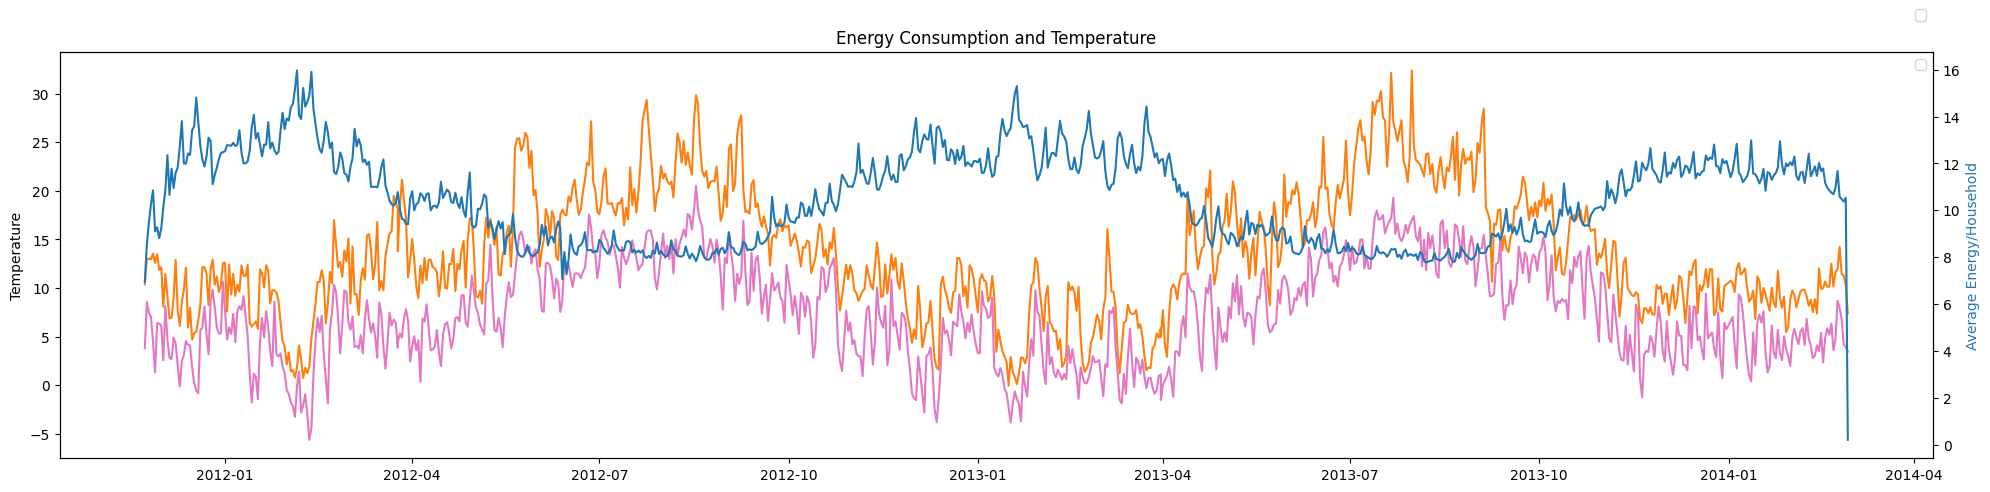

In [208]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.temperatureMax, color = 'tab:orange')
ax1.plot(weather_energy.day, weather_energy.temperatureMin, color = 'tab:pink')
ax1.set_ylabel('Temperature')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Temperature')
fig.tight_layout()
plt.show()


***2.  Humidity ***

>  Humidity and the average consumption of energy seems to have the same trend.


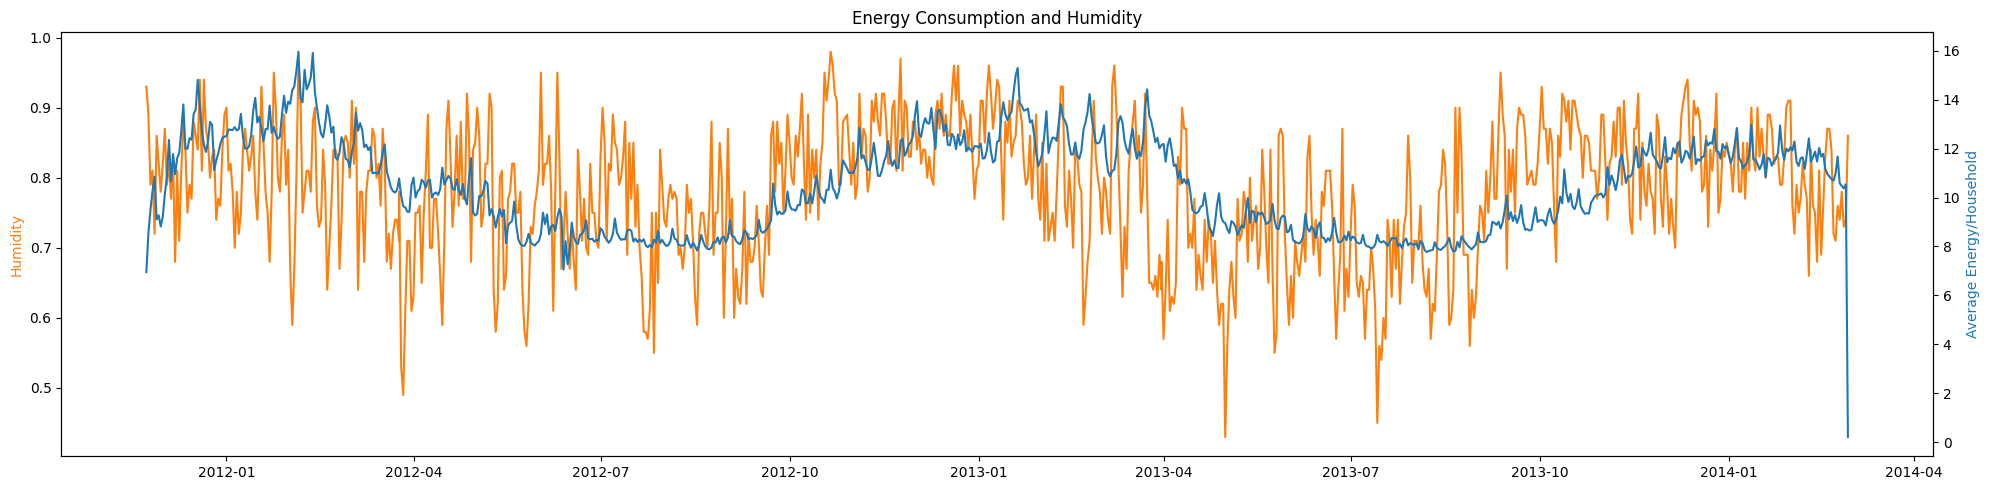

In [209]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.humidity, color = 'tab:orange')
ax1.set_ylabel('Humidity',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Humidity')
fig.tight_layout()
plt.show()

***3. Cloud Cover***
> The cloud cover value seems to be following the same pattern as the energy consumption.

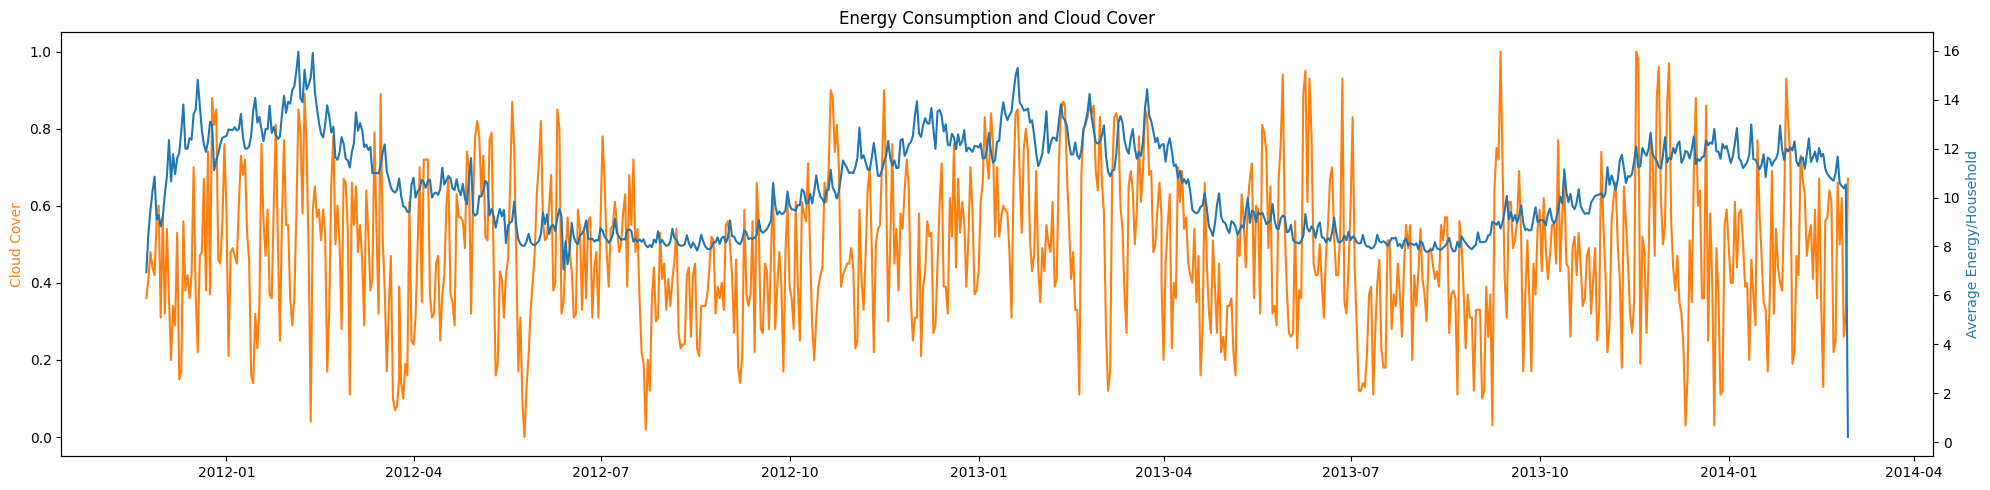

In [210]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.cloudCover, color = 'tab:orange')
ax1.set_ylabel('Cloud Cover',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Cloud Cover')
fig.tight_layout()
plt.show()

***4. Visibility***
> The visibility factor does not seem to affect energy consumption at all- since visibility is most likely an outdoors factor, it is unlikely that it's increase or decrease affects energy consumption within a household.

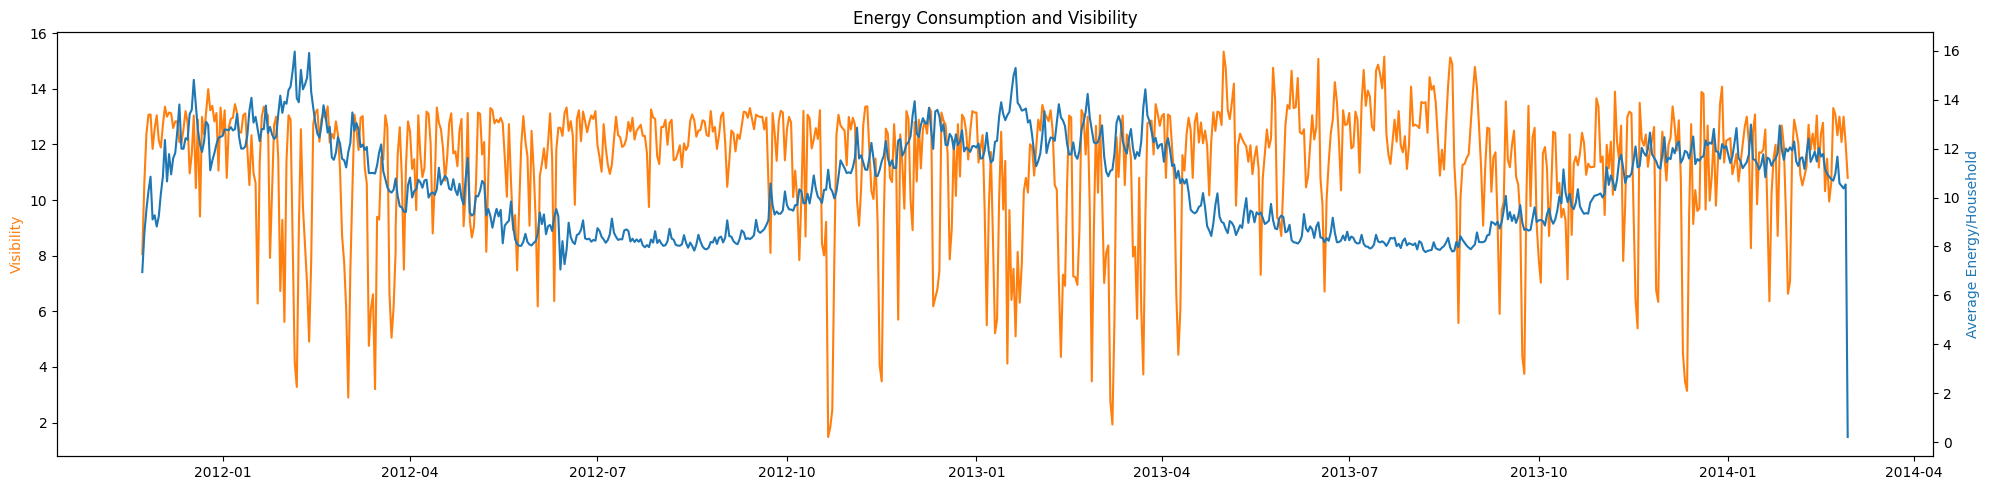

In [211]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.visibility, color = 'tab:orange')
ax1.set_ylabel('Visibility',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Visibility')
fig.tight_layout()
plt.show()

***5.  Wind Speed***
>  Like visibility, wind speed seems to be an outdoors factor which does not affect in the energy consumption as such.

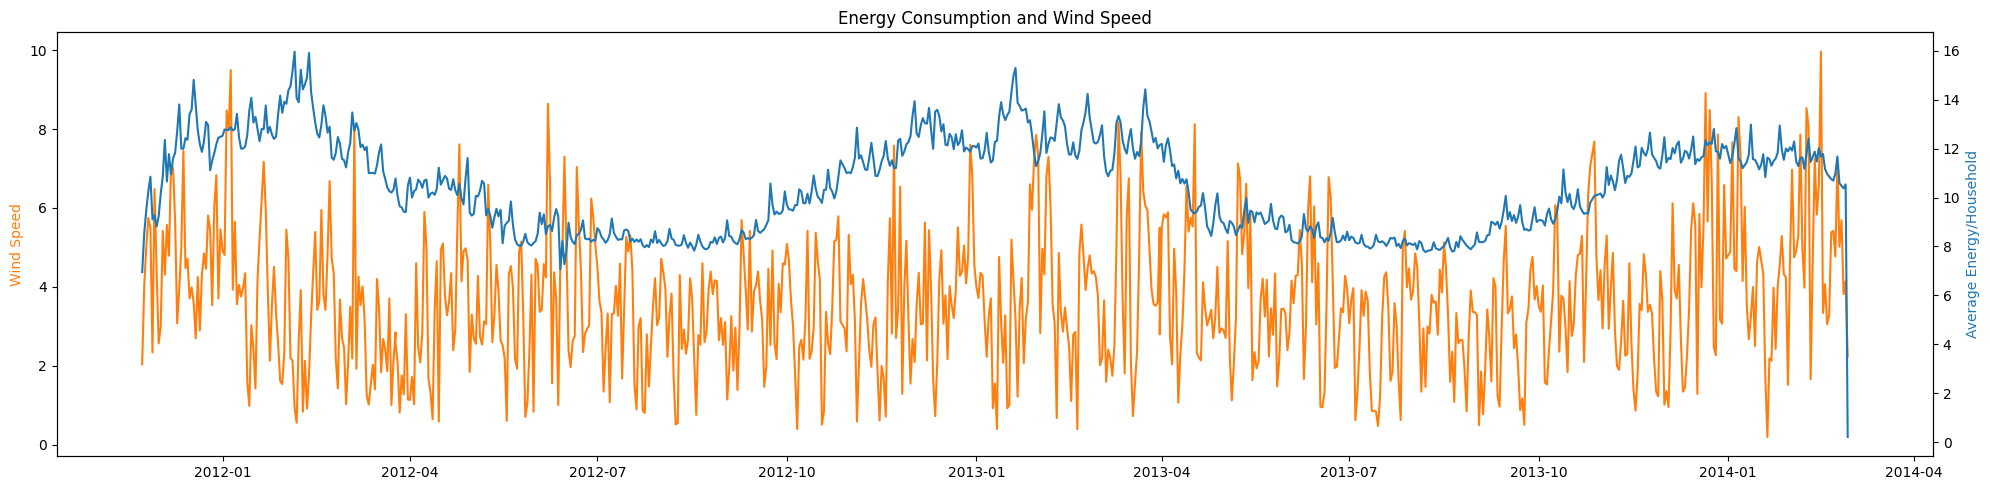

In [212]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.windSpeed, color = 'tab:orange')
ax1.set_ylabel('Wind Speed',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Wind Speed')
fig.tight_layout()
plt.show()

***6.  UV Index***
> The UV index has an inverse relationship with energy consumption- why?

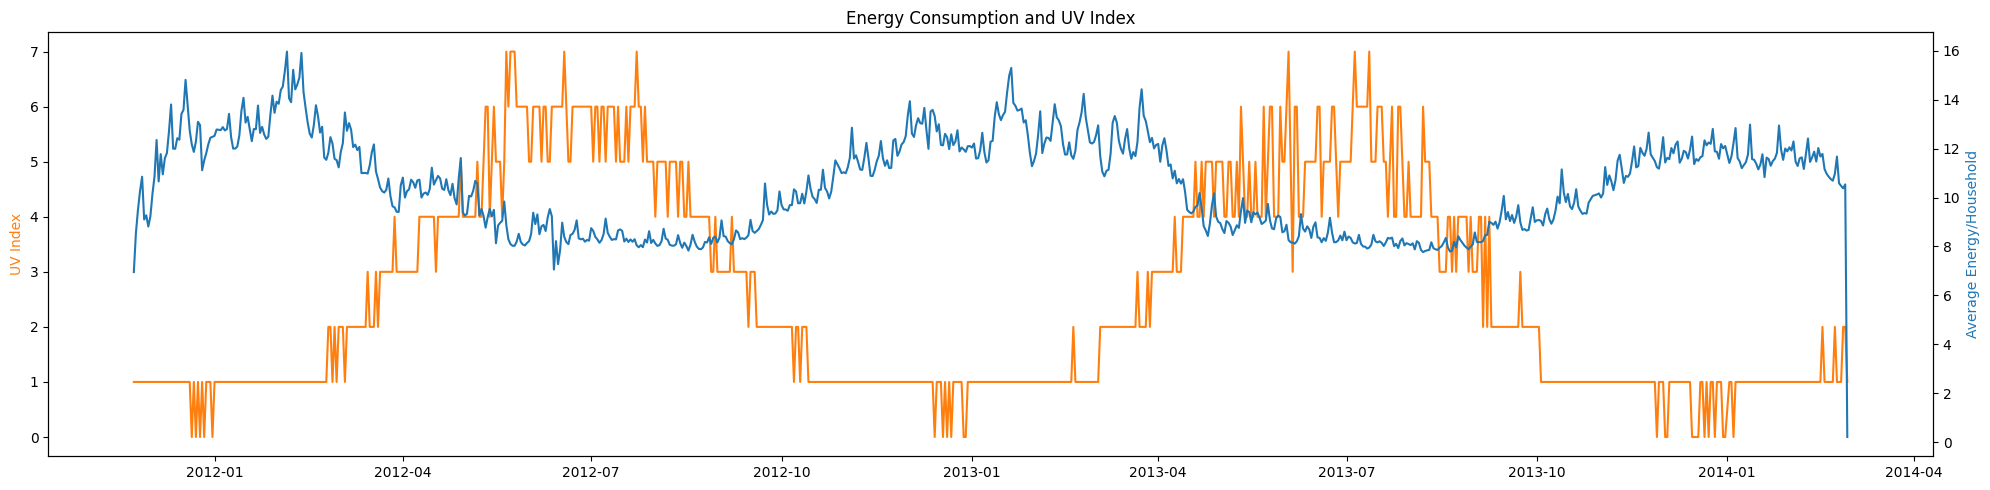

In [213]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.uvIndex, color = 'tab:orange')
ax1.set_ylabel('UV Index',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and UV Index')
fig.tight_layout()
plt.show()

***7. dewPoint***
> Dew Point- is a function of humidity and temperature therefore it displays similar relation to energy consumption.

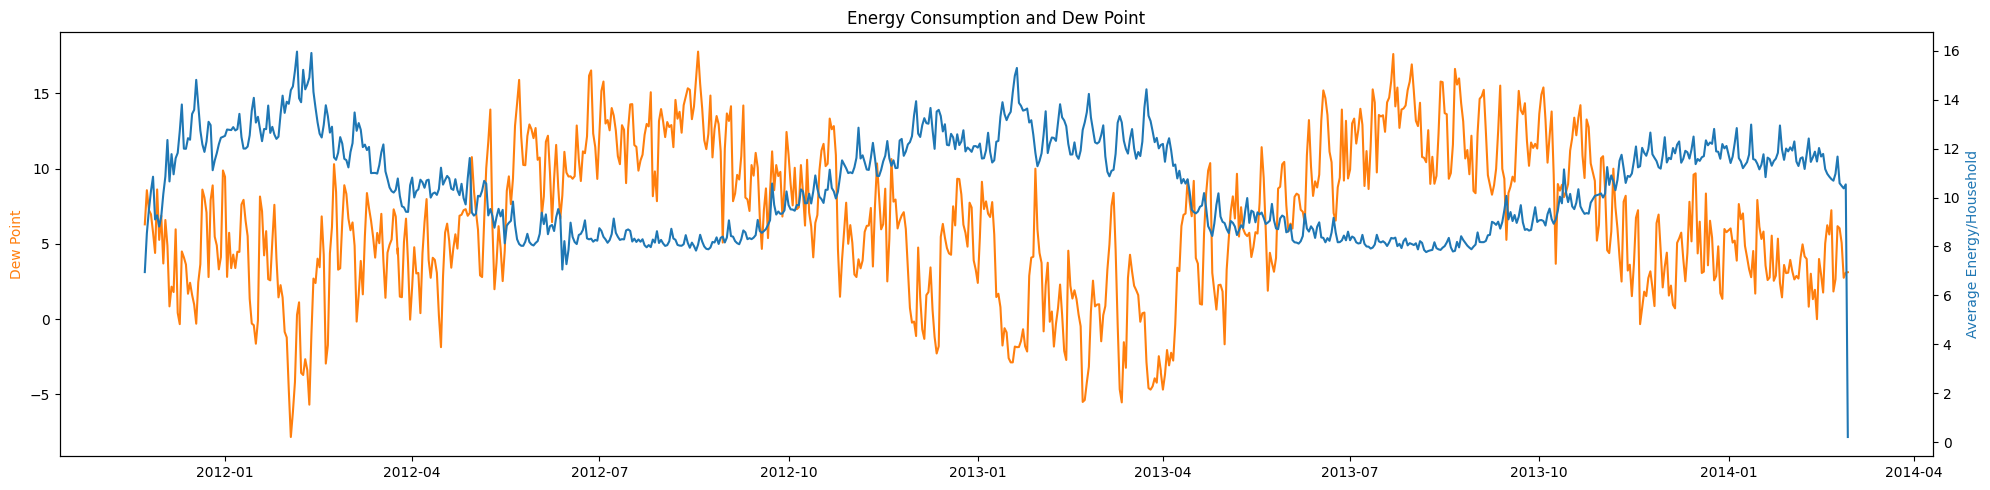

In [214]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.dewPoint, color = 'tab:orange')
ax1.set_ylabel('Dew Point',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Dew Point')
fig.tight_layout()
plt.show()

### Correlation between Weather Variables and Energy Consumption
* Energy has high positive correlation with humidity and high negative correlation with temperature.
* Dew Point, UV Index display multicollinearity with Temperature, hence discarded
* Cloud Cover and Visibility display multicollinearity with Humidity, hence discarded
* Pressure and Moon Phase have minimal correlation with Energy, hence discarded
* Wind Speed has low correlation with energy but does not show multicollinearity


In [215]:
cor_matrix = weather_energy[['avg_energy','temperatureMax','dewPoint', 'cloudCover', 'windSpeed','pressure', 'visibility', 'humidity','uvIndex', 'moonPhase']].corr()
cor_matrix

,avg_energy,temperatureMax,dewPoint,cloudCover,windSpeed,pressure,visibility,humidity,uvIndex,moonPhase
avg_energy,1.000000,-0.846965,-0.755901,0.241779,0.149624,-0.028851,-0.246404,0.361237,-0.733171,-0.031716
temperatureMax,-0.846965,1.000000,0.865038,-0.333409,-0.153602,0.118933,0.259108,-0.404899,0.696497,0.003636
dewPoint,-0.755901,0.865038,1.000000,-0.025207,-0.092212,-0.028121,0.042633,0.055514,0.486692,-0.008239
cloudCover,0.241779,-0.333409,-0.025207,1.000000,0.170235,-0.101079,-0.330177,0.480056,-0.248695,-0.062126
windSpeed,0.149624,-0.153602,-0.092212,0.170235,1.000000,-0.344354,0.281088,-0.042391,-0.152634,-0.023273
pressure,-0.028851,0.118933,-0.028121,-0.101079,-0.344354,1.000000,-0.012508,-0.250941,0.100774,0.038462
visibility,-0.246404,0.259108,0.042633,-0.330177,0.281088,-0.012508,1.000000,-0.578130,0.240485,0.062813
humidity,0.361237,-0.404899,0.055514,0.480056,-0.042391,-0.250941,-0.578130,1.000000,-0.533919,-0.013997
uvIndex,-0.733171,0.696497,0.486692,-0.248695,-0.152634,0.100774,0.240485,-0.533919,1.000000,0.012833
moonPhase,-0.031716,0.003636,-0.008239,-0.062126,-0.023273,0.038462,0.062813,-0.013997,0.012833,1.000000


### Creating Weather Clusters
> The weather information has a lot of variables- which might not all be useful. We will attempt to create weather clusters to see if we can define a weather of the day based on the granular weather data like temperature, precipitation etc.

In [216]:
#scaling
scaler = MinMaxScaler()
weather_scaled = scaler.fit_transform(weather_energy[['temperatureMax','humidity','windSpeed']])

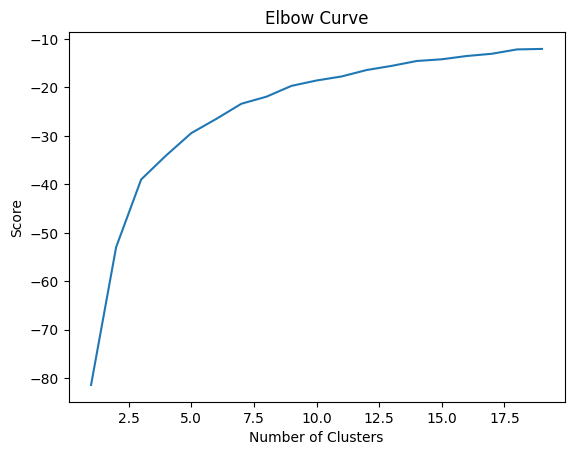

In [217]:
# optimum K
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans

score = [kmeans[i].fit(weather_scaled).score(weather_scaled) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [218]:
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'lloyd')
kmeans.fit(weather_scaled)
weather_energy['weather_cluster'] = kmeans.labels_

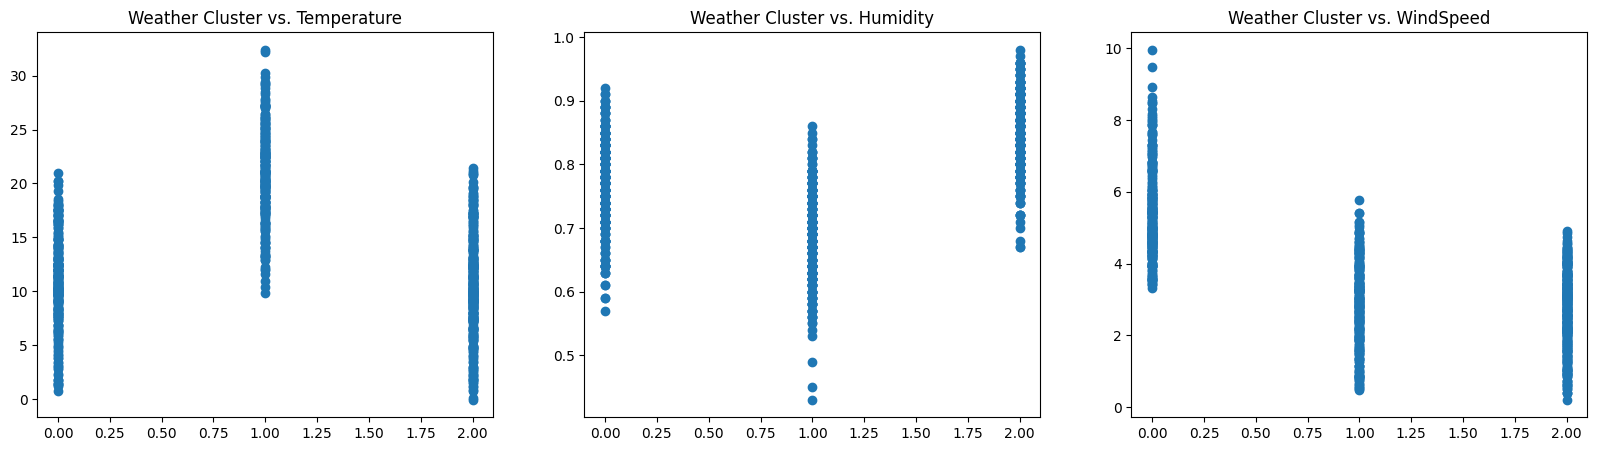

In [219]:
# Cluster Relationships with weather variables
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.scatter(weather_energy.weather_cluster,weather_energy.temperatureMax)
plt.title('Weather Cluster vs. Temperature')
plt.subplot(1, 3, 2)
plt.scatter(weather_energy.weather_cluster,weather_energy.humidity)
plt.title('Weather Cluster vs. Humidity')
plt.subplot(1, 3, 3)
plt.scatter(weather_energy.weather_cluster,weather_energy.windSpeed)
plt.title('Weather Cluster vs. WindSpeed')

plt.show()
# put this in a loop

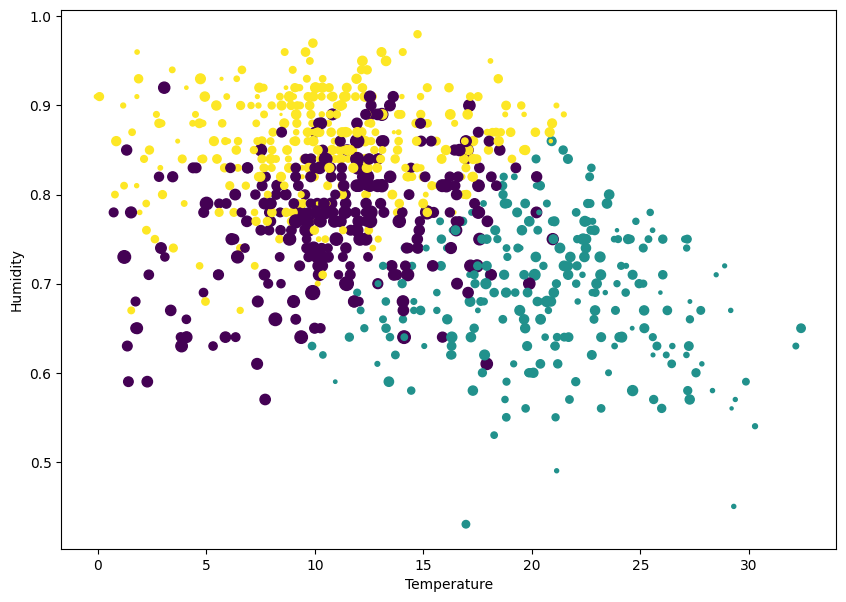

In [220]:
fig, ax1 = plt.subplots(figsize = (10,7))
ax1.scatter(weather_energy.temperatureMax,
            weather_energy.humidity,
            s = weather_energy.windSpeed*10,
            c = weather_energy.weather_cluster)
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Humidity')
plt.show()

### UK Bank Holidays

In [221]:
holiday = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project Energy/Input/uk_bank_holidays.csv')
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays'],format='%Y-%m-%d').dt.date
holiday.head(4)

,Bank holidays,Type
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)


**Creating a holiday indicator on weather data**

In [222]:
weather_energy = weather_energy.merge(holiday, left_on = 'day',right_on = 'Bank holidays',how = 'left')
weather_energy['holiday_ind'] = np.where(weather_energy['Bank holidays'].isna(),0,1)

In [223]:
weather_energy

,day,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,...,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,weather_cluster,Bank holidays,Type,holiday_ind
0,2011-11-23,90.385000,13,6.952692,10.36,229,6.29,0.36,2.04,1027.12,...,1.0,8.24,3.81,10.36,2.18,0.94,2,NaN,NaN,0
1,2011-11-24,213.412000,25,8.536480,12.93,204,8.56,0.41,4.04,1027.22,...,1.0,9.71,8.56,12.93,7.01,0.97,2,NaN,NaN,0
2,2011-11-25,303.993000,32,9.499781,13.03,243,7.24,0.48,5.02,1024.47,...,1.0,7.01,7.46,12.27,4.84,0.01,0,NaN,NaN,0
3,2011-11-26,420.976000,41,10.267707,12.96,237,6.96,0.44,5.75,1025.80,...,1.0,11.59,7.01,12.96,4.69,0.05,0,NaN,NaN,0
4,2011-11-27,444.883001,41,10.850805,13.54,256,5.76,0.42,5.48,1021.11,...,1.0,1.31,4.47,13.54,2.94,0.08,0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,2014-02-24,52867.660004,4994,10.586235,14.23,183,6.03,0.50,5.02,1005.19,...,1.0,8.25,7.99,14.23,5.52,0.82,0,NaN,NaN,0
824,2014-02-25,52330.109999,4995,10.476498,11.43,202,5.06,0.62,5.69,1000.65,...,1.0,4.17,6.79,10.31,3.89,0.86,0,NaN,NaN,0
825,2014-02-26,51804.199995,4993,10.375366,11.29,227,2.74,0.26,3.82,1012.73,...,2.0,6.01,4.17,11.29,1.67,0.90,0,NaN,NaN,0
826,2014-02-27,52580.878999,4990,10.537250,10.31,224,3.08,0.32,4.14,1007.02,...,2.0,3.43,3.93,10.31,1.41,0.93,0,NaN,NaN,0


In [224]:
from datetime import date
# --- ensure day is DATE (not datetime, not normalized) ---
weather_energy["day"] = pd.to_datetime(weather_energy["day"]).dt.date

target = date(2014, 1, 1)
prev_day = date(2013, 12, 31)
next_day = date(2014, 1, 2)

# --- 1) check duplicate days ---
dup_days = weather_energy["day"].duplicated(keep=False)

if dup_days.any():
    print("❌ Duplicate days found:")
    display(weather_energy.loc[dup_days].sort_values("day"))
else:
    print("✅ No duplicate days found.")

weather_energy = weather_energy.drop(weather_energy.index[[124, 435]])

# --- 2) insert missing day using average ---
exists = (weather_energy["day"] == target).any()

numeric_cols = weather_energy.select_dtypes(include=[np.number]).columns
avg_cols = [c for c in numeric_cols if c != "is_Holiday"]

if not exists:
    prev_row = weather_energy.loc[weather_energy["day"] == prev_day]
    next_row = weather_energy.loc[weather_energy["day"] == next_day]

    if prev_row.empty or next_row.empty:
        raise ValueError("Missing 2013-12-31 or 2014-01-02")

    new_row = {"day": target}

    for c in avg_cols:
        new_row[c] = (prev_row.iloc[0][c] + next_row.iloc[0][c]) / 2

    new_row["holiday_ind"] = 1

    weather_energy = (
        pd.concat([weather_energy, pd.DataFrame([new_row])], ignore_index=True)
        .sort_values("day")
        .reset_index(drop=True)
    )

    print("✅ Inserted 2014-01-01 using neighbor average.")
else:
    print("ℹ️ 2014-01-01 already exists.")

# --- 3) force holiday flag ---
weather_energy.loc[weather_energy["day"] == target, "holiday_ind"] = 1

# --- verify ---
display(weather_energy.loc[weather_energy["day"] == target])

❌ Duplicate days found:


,day,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,...,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,weather_cluster,Bank holidays,Type,holiday_ind
123,2012-03-25,12814.888002,1189,10.777870,18.18,77,4.30,0.15,2.85,1036.22,...,3.0,5.32,3.84,18.18,2.40,0.12,1,NaN,NaN,0
124,2012-03-25,12814.888002,1189,10.777870,13.79,70,4.69,0.39,2.58,1033.50,...,3.0,3.84,4.40,13.79,2.47,0.09,2,NaN,NaN,0
494,2013-03-31,65729.952009,5410,12.149714,5.88,68,-3.45,0.57,5.50,1011.52,...,3.0,0.04,1.10,5.88,-3.14,0.68,0,NaN,NaN,0
495,2013-03-31,65729.952009,5410,12.149714,4.96,67,-3.57,0.40,2.80,1014.56,...,3.0,1.10,-1.54,4.96,-2.33,0.65,2,NaN,NaN,0


✅ Inserted 2014-01-01 using neighbor average.


,day,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,...,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,weather_cluster,Bank holidays,Type,holiday_ind
768,2014-01-01,59971.392001,5100.0,11.759165,10.555,200.0,5.895,0.495,4.805,998.79,...,0.5,7.155,6.155,10.315,3.075,0.5,0.0,NaN,NaN,1


In [227]:
start_date = weather_energy["day"].min()
end_date = weather_energy["day"].max()

full_range = pd.date_range(start=start_date, end=end_date).date
existing_dates = set(weather_energy["day"])
missing_dates = sorted(set(full_range) - existing_dates)
if missing_dates:
    print(f"❌ Missing {len(missing_dates)} date(s):")
    print(missing_dates[:10])  # preview first 10
else:
    print("✅ No missing dates — dataset is continuous.")


✅ No missing dates — dataset is continuous.


In [226]:
from datetime import timedelta
numeric_cols = weather_energy.select_dtypes(include=[np.number]).columns
avg_cols = [c for c in numeric_cols if c != "holiday_ind"]

new_rows = []

for d in missing_dates:
    prev_day = d - timedelta(days=1)
    next_day = d + timedelta(days=1)

    prev_row = weather_energy.loc[weather_energy["day"] == prev_day]
    next_row = weather_energy.loc[weather_energy["day"] == next_day]

    if prev_row.empty or next_row.empty:
        print(f"⚠️ Skipping {d}: neighbor missing")
        continue

    row = {"day": d}

    for c in avg_cols:
        row[c] = (prev_row.iloc[0][c] + next_row.iloc[0][c]) / 2

    # preserve holiday logic if column exists
    if "holiday_ind" in weather_energy.columns:
        row["holiday_ind"] = 0

    new_rows.append(row)

# insert rows
if new_rows:
    weather_energy = (
        pd.concat([weather_energy, pd.DataFrame(new_rows)], ignore_index=True)
        .sort_values("day")
        .reset_index(drop=True)
    )
    print(f"✅ Inserted {len(new_rows)} missing date(s).")
else:
    print("ℹ️ No rows inserted.")

✅ Inserted 3 missing date(s).


### ARIMAX

In [375]:
weather_energy['Year'] = pd.DatetimeIndex(weather_energy['day']).year
weather_energy['Month'] = pd.DatetimeIndex(weather_energy['day']).month
weather_energy.set_index(['day'],inplace=True)

KeyError: 'day'

** Subset for required columns and 70-30 train-test split**

In [376]:
model_data = weather_energy[['avg_energy','temperatureMax','holiday_ind']]
# train = model_data.iloc[0:round(len(model_data)*0.90)]
# test = model_data.iloc[len(train)-1:]
train = model_data.iloc[0:(len(model_data)-59)]
test = model_data.iloc[len(train):(len(model_data)-1)]

<Axes: xlabel='day'>

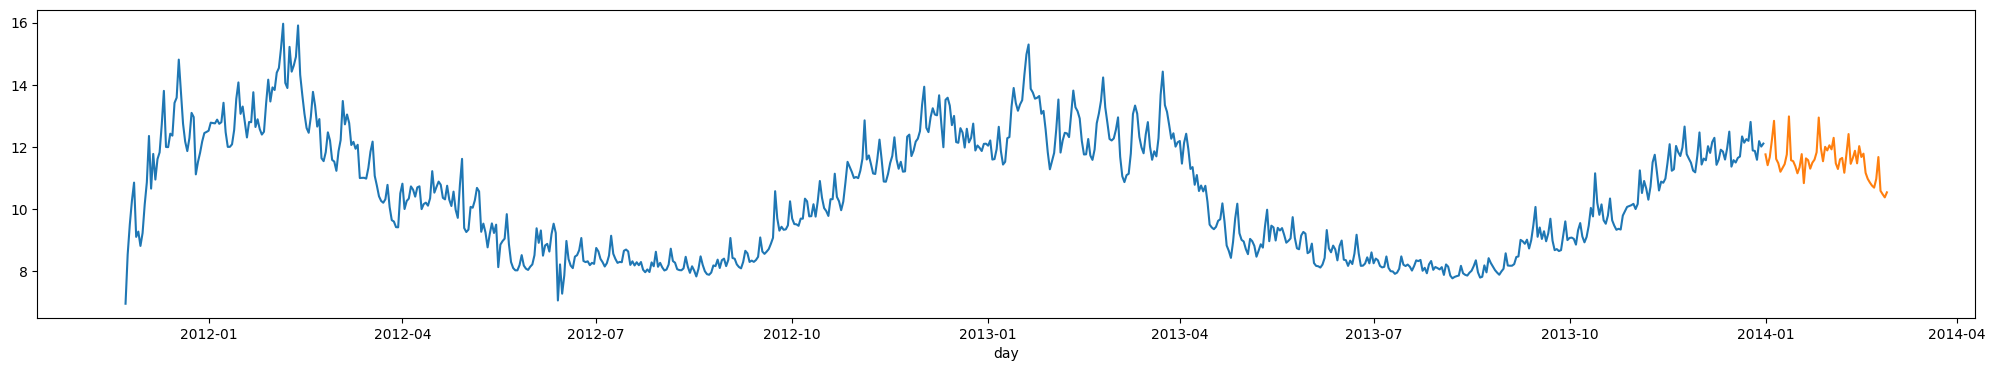

In [377]:
train['avg_energy'].plot(figsize=(25,4))
test['avg_energy'].plot(figsize=(25,4))


In [378]:
train.tail(1)

,avg_energy,temperatureMax,holiday_ind
day,,,
2013-12-31,12.107017,10.36,0


In [379]:
test.head(1)

,avg_energy,temperatureMax,holiday_ind
day,,,
2014-01-01,11.759165,10.555,1


**ACF PACF **

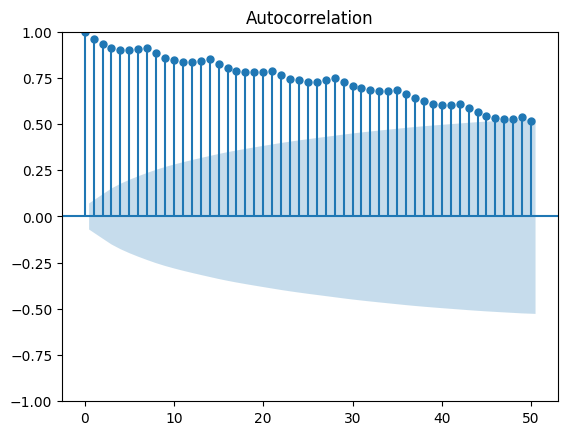

In [380]:
plot_acf(train.avg_energy,lags=50)
plt.show()

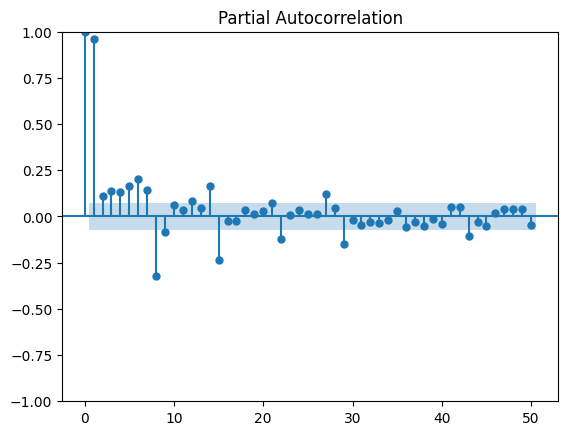

In [381]:
plot_pacf(train.avg_energy,lags=50)
plt.show()

Autocorrelation plot shows gradual decay while Partial AutoCorrelation shows that there is a sharp drop after 1st lag. This means that most of the higher-order autocorrelations are effectively explained by the k = 1 lag. Therefore, the series displays AR 'signature'

**Dickey Fuller's Test**
> p is greater than 0.05 therefore the data is not stationary. After differencing, p < 0.05.

In [382]:
t = sm.tsa.adfuller(train.avg_energy, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

,0
Test Statistic,-1.802564
p-value,0.379189
#Lags Used,14.000000
Number of Observations Used,756.000000


In [383]:
# function for differencing
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff

In [384]:
t  = sm.tsa.adfuller(difference(train.avg_energy,1), autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

,0
Test Statistic,-6.553222e+00
p-value,8.745184e-09
#Lags Used,2.000000e+01
Number of Observations Used,7.490000e+02


In [385]:
t

(np.float64(-6.553222213885933),
 np.float64(8.745184132971562e-09),
 20,
 749,
 {'1%': np.float64(-3.439110818166223),
  '5%': np.float64(-2.8654065210185795),
  '10%': np.float64(-2.568828945705979)},
 np.float64(788.3197909710559))

**Seasonal Decomposition**
> The seasonal component is quite low while the trend is quite strong with obvious dips in electricity consumption during summers i.e. April to September. This may be attributed to longer days during summer.

In [386]:
s = sm.tsa.seasonal_decompose(train.avg_energy,period=60)

<Axes: xlabel='day'>

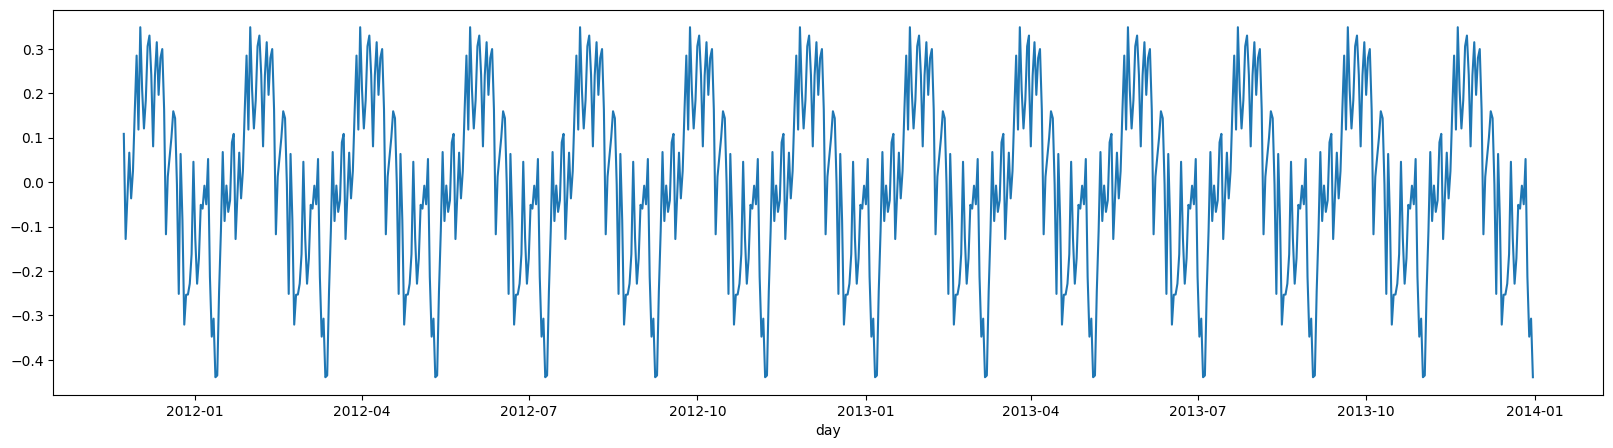

In [387]:
s.seasonal.plot(figsize=(20,5))

<Axes: xlabel='day'>

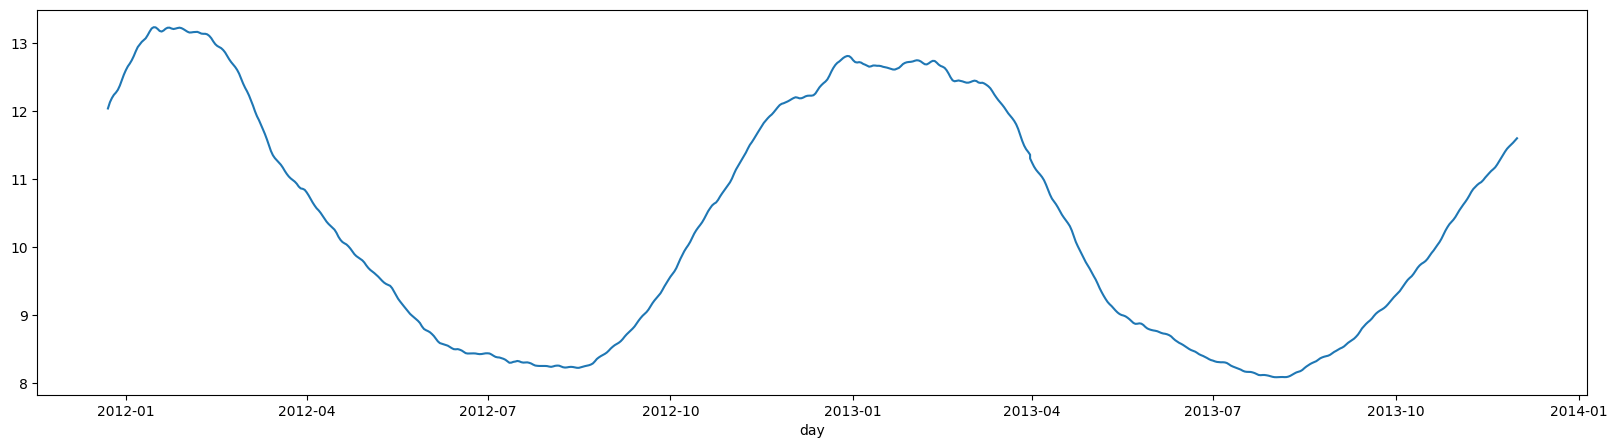

In [388]:
s.trend.plot(figsize=(20,5))

<Axes: xlabel='day'>

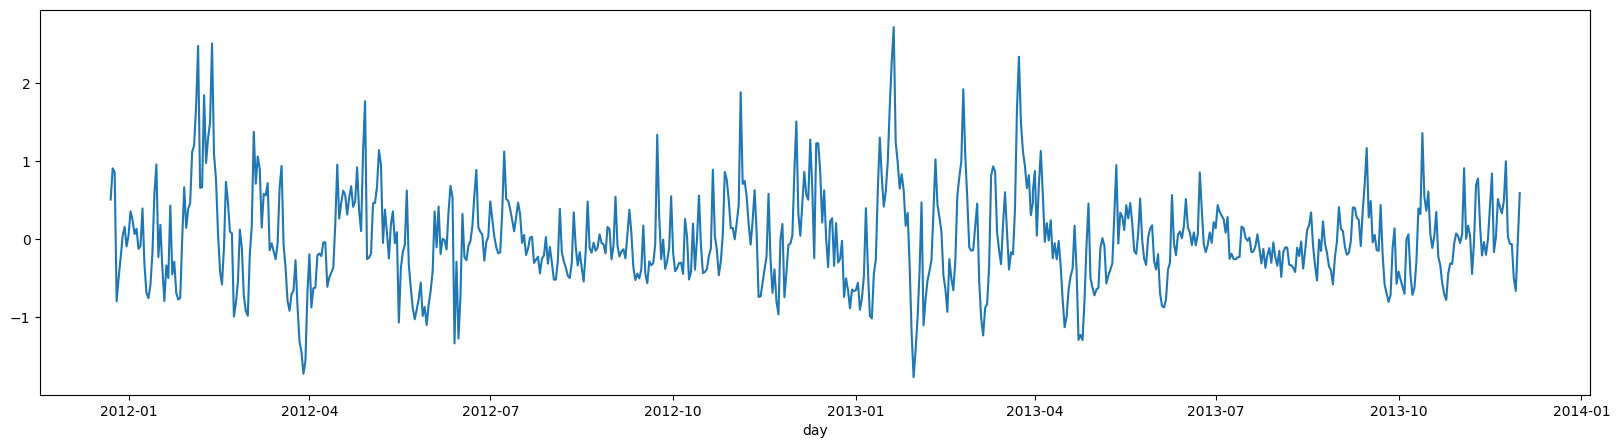

In [389]:
s.resid.plot(figsize=(20,5))

In [390]:
train

,avg_energy,temperatureMax,holiday_ind
day,,,
2011-11-23,6.952692,10.36,0
2011-11-24,8.536480,12.93,0
2011-11-25,9.499781,13.03,0
2011-11-26,10.267707,12.96,0
2011-11-27,10.850805,13.54,0
...,...,...,...
2013-12-27,11.869615,10.99,0
2013-12-28,11.584356,7.81,0
2013-12-29,12.185339,7.56,0


In [417]:
endog = train['avg_energy']
exog  = train[['temperatureMax']]

mod = sm.tsa.statespace.SARIMAX(
    endog=endog,
    exog=exog,
    order=(6,1,1),
    seasonal_order=(1,1,0,7),
    trend='c'     # <--- no trend because exog already has constant
)

model_fit = mod.fit(disp=False)
model_fit.summary()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         avg_energy   No. Observations:                  771
Model:             SARIMAX(6, 1, 1)x(1, 1, [], 7)   Log Likelihood                -453.093
Date:                            Sat, 10 Jan 2026   AIC                            928.186
Time:                                    21:54:01   BIC                            979.196
Sample:                                         0   HQIC                           947.825
                                            - 771                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -0.0076      0.026     -0.288      0.773      -0.059       0.044
temperatureMax    -0.0355      0.005     -7.386      0.000      -0.045      -0.026
ar.L1             -0.8554      0.152     -5.610      0.000      -1.154      -0.557
ar.L2             -0.2816      0.057     -4.944      0.000      -0.393      -0.170
ar.L3             -0.1300      0.048     -2.704      0.007      -0.224      -0.036
ar.L4             -0.1073      0.049     -2.189      0.029      -0.203      -0.011
ar.L5             -0.0965      0.045     -2.122      0.034      -0.186      -0.007
ar.L6              0.0726      0.047      1.536      0.125      -0.020       0.165
ma.L1              0.5980      0.150      3.981      0.000       0.304       0.892
ar.S.L7           -0.4784      0.035    -13.545      0.000      -0.548      -0.409
sigma2             0.1913      0.008     23.688      0.000       0.175       0.207
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                47.29
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Model Fit**

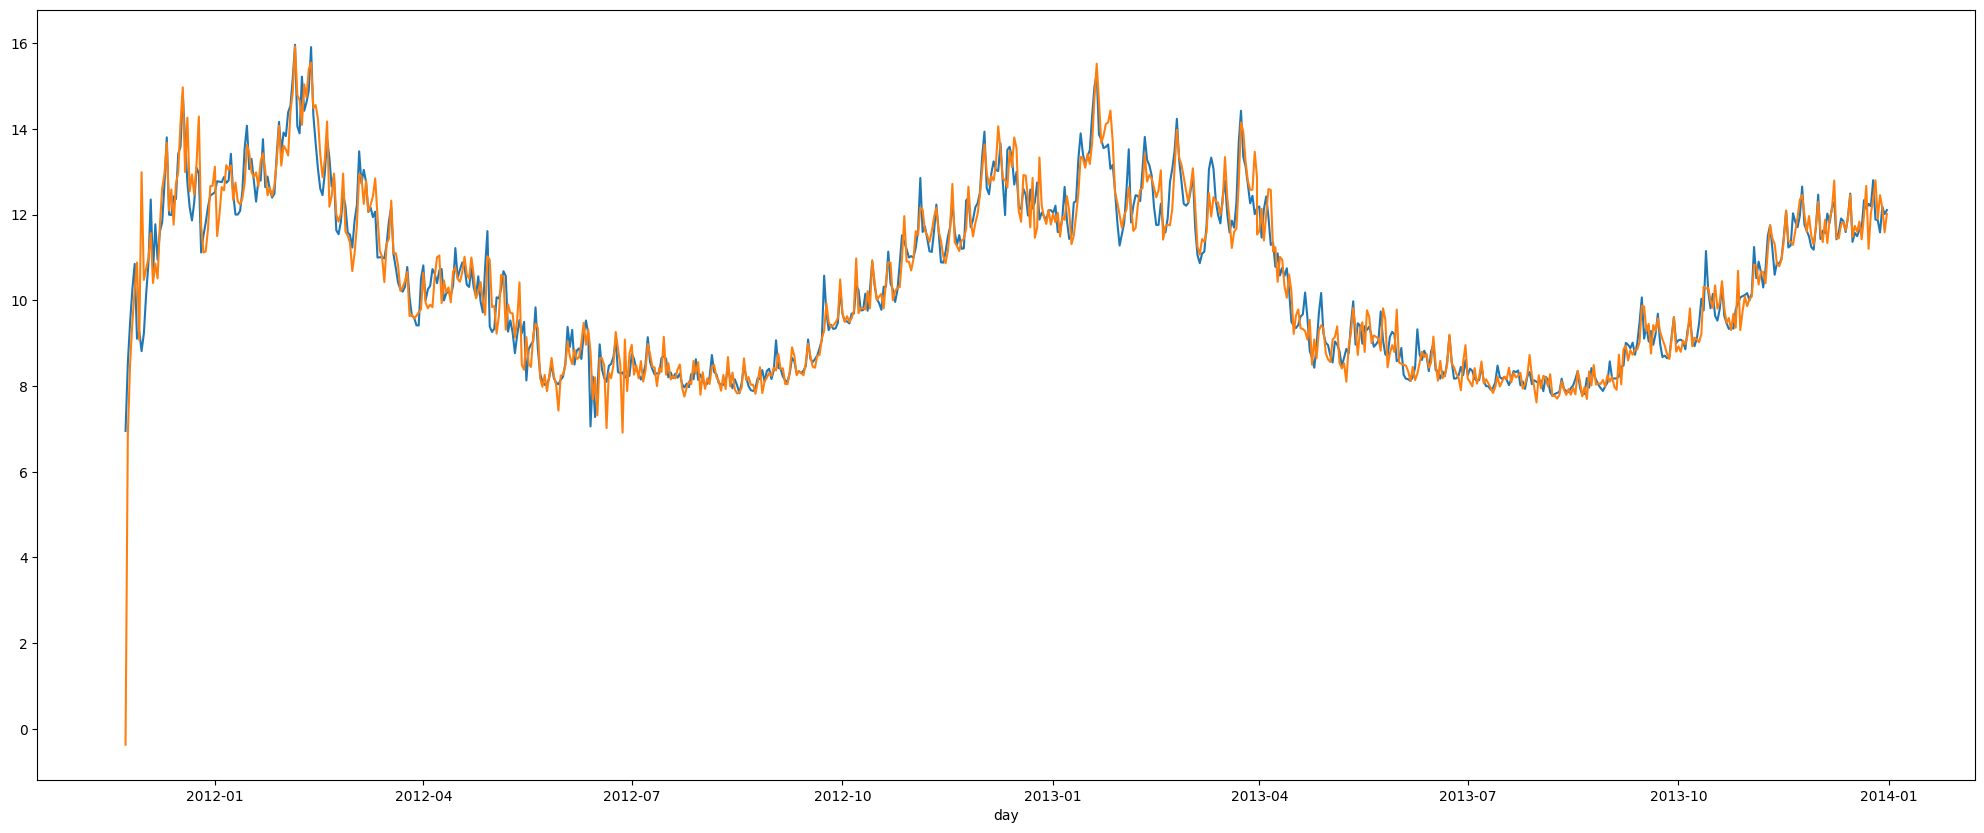

In [418]:
train['avg_energy'].plot(figsize=(25,10))
model_fit.fittedvalues.plot()
plt.show()

**Prediction**

In [419]:
predict = model_fit.predict(
    start=len(train),
    end=len(train) + len(test) - 1,
    exog=test[['temperatureMax']]
)

test['predicted'] = predict.values
test.tail(5)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/tmp/ipython-input-764459880.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted'] = predict.values


,avg_energy,temperatureMax,holiday_ind,predicted,residual,abs_error
day,,,,,,
2014-02-23,11.673756,11.94,0,11.866862,-0.350486,0.350486
2014-02-24,10.586235,14.23,0,11.793457,-1.372106,1.372106
2014-02-25,10.476498,11.43,0,11.902071,-1.594456,1.594456
2014-02-26,10.375366,11.29,0,12.080692,-1.905901,1.905901
2014-02-27,10.537250,10.31,0,11.590944,-1.260740,1.260740


In [420]:
# Absolute errors
test['residual'] = test['avg_energy'] - test['predicted']
test['abs_error'] = test['residual'].abs()

# MAE
MAE = test['abs_error'].mean()

# MAPE (safe: exclude zero actuals)
MAPE = (
    test.loc[test['avg_energy'] != 0, 'abs_error']
    / test.loc[test['avg_energy'] != 0, 'avg_energy']
).mean() * 100

print("MAE:", MAE)
print("MAPE:", MAPE)


MAE: 0.5941251439432873
MAPE: 5.260774770517535


/tmp/ipython-input-3392553741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['residual'] = test['avg_energy'] - test['predicted']
/tmp/ipython-input-3392553741.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['abs_error'] = test['residual'].abs()


In [421]:
RMSE = np.sqrt((test['residual'] ** 2).mean())
print("RMSE:", RMSE)

RMSE: 0.711379862501962


In [422]:
sMAPE = (
    2 * test['abs_error'] /
    (test['avg_energy'].abs() + test['predicted'].abs())
).mean() * 100

print("sMAPE:", sMAPE)


sMAPE: 5.086690169923874


In [423]:
naive_error = (test['avg_energy'] - test['avg_energy'].shift(7)).abs().mean()
MASE = MAE / naive_error
print("MASE:", MASE)


MASE: 1.4193864642804925


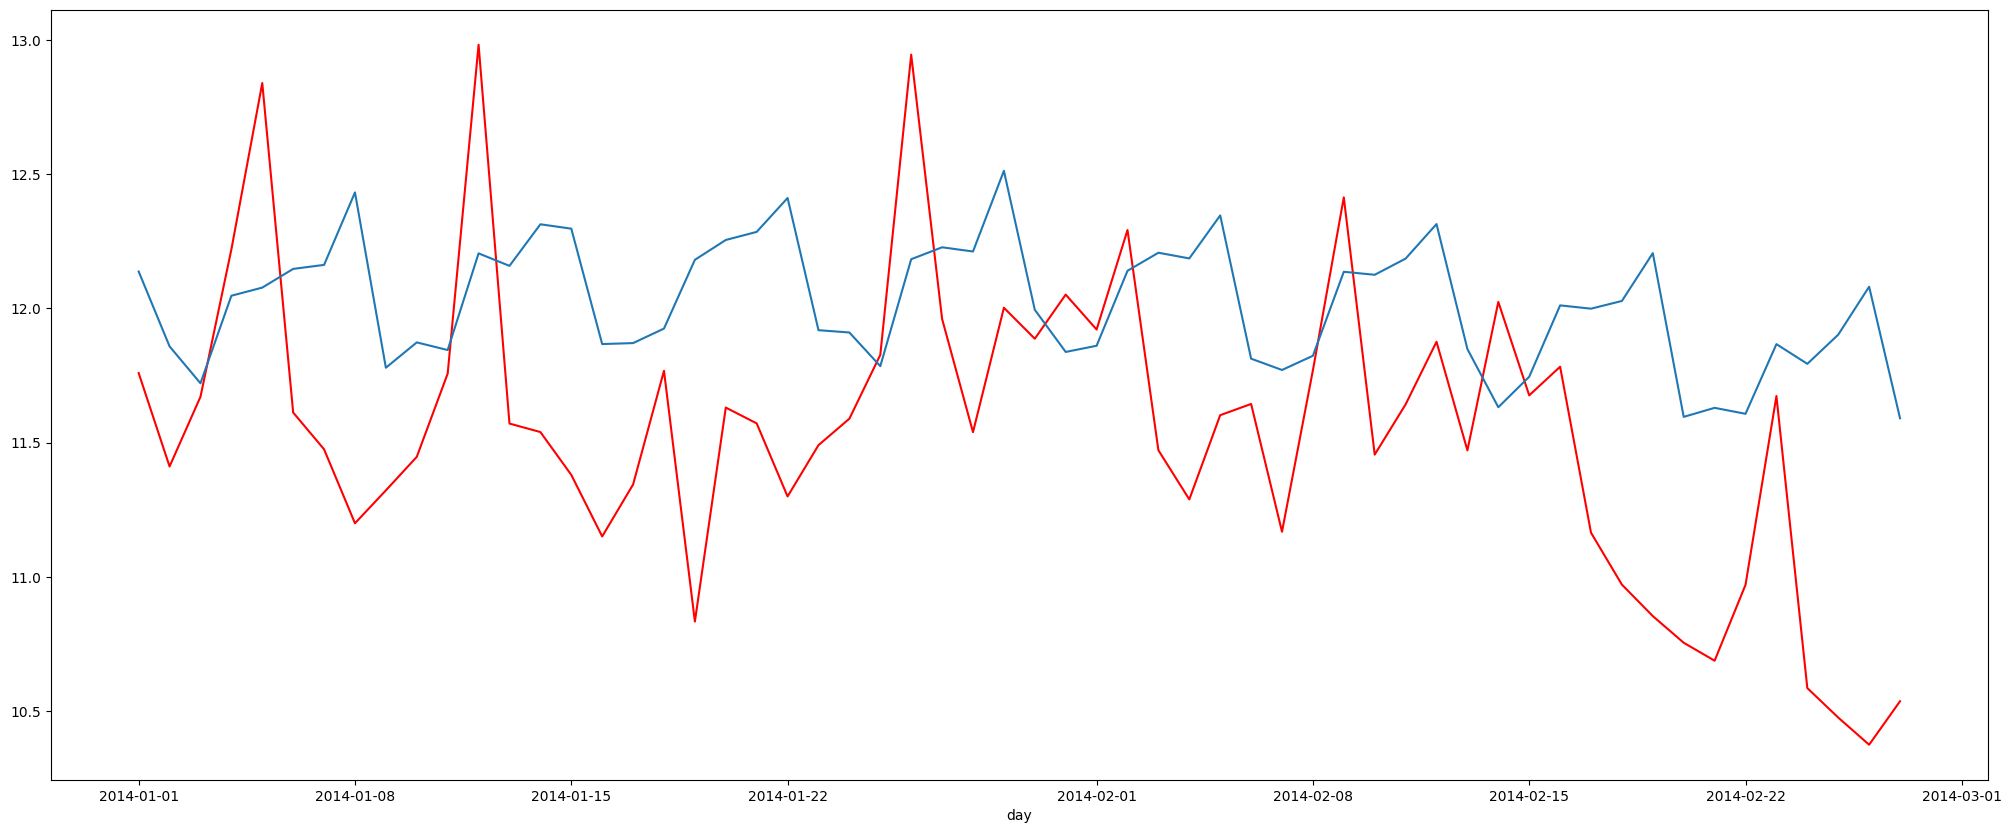

In [424]:
test['avg_energy'].plot(figsize=(25,10),color = 'red')
test['predicted'].plot()
plt.show()

<Axes: xlabel='day'>

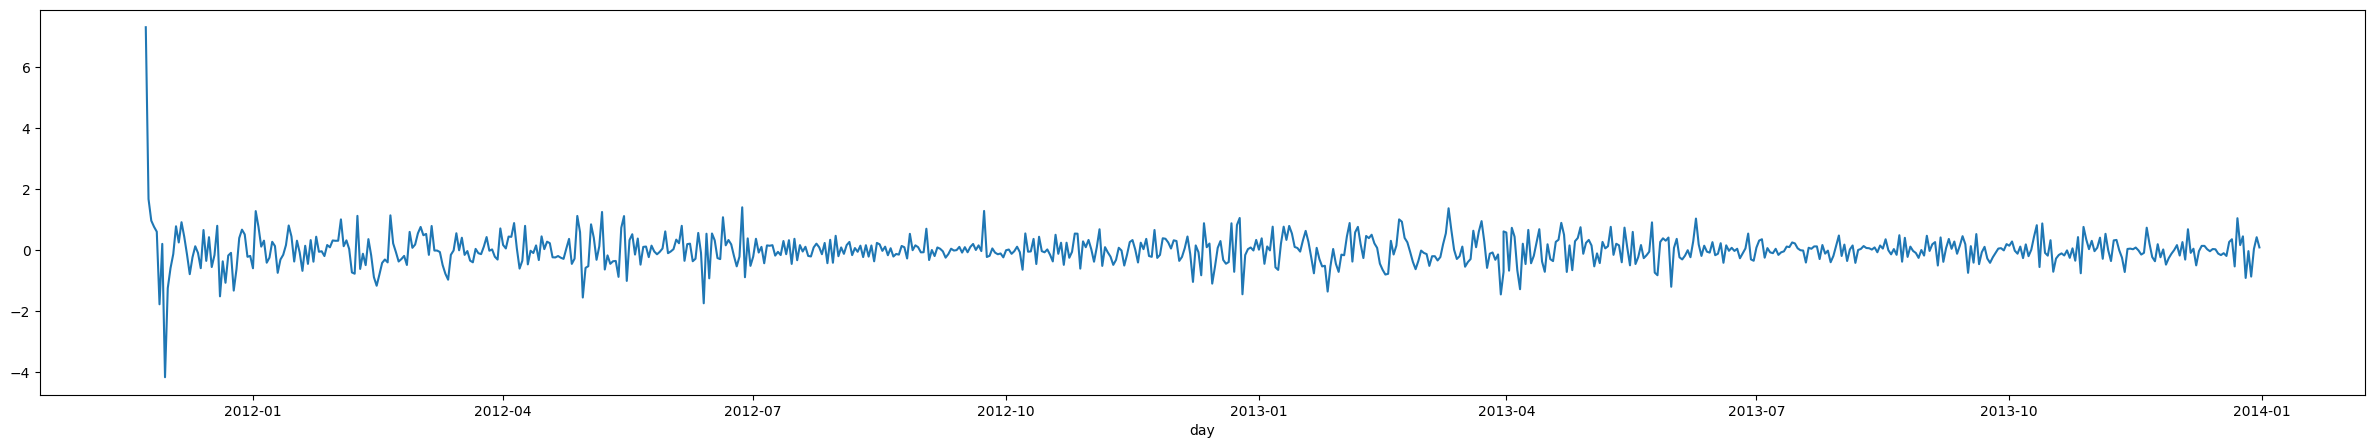

In [425]:
model_fit.resid.plot(figsize= (30,5))

<Axes: xlabel='day'>

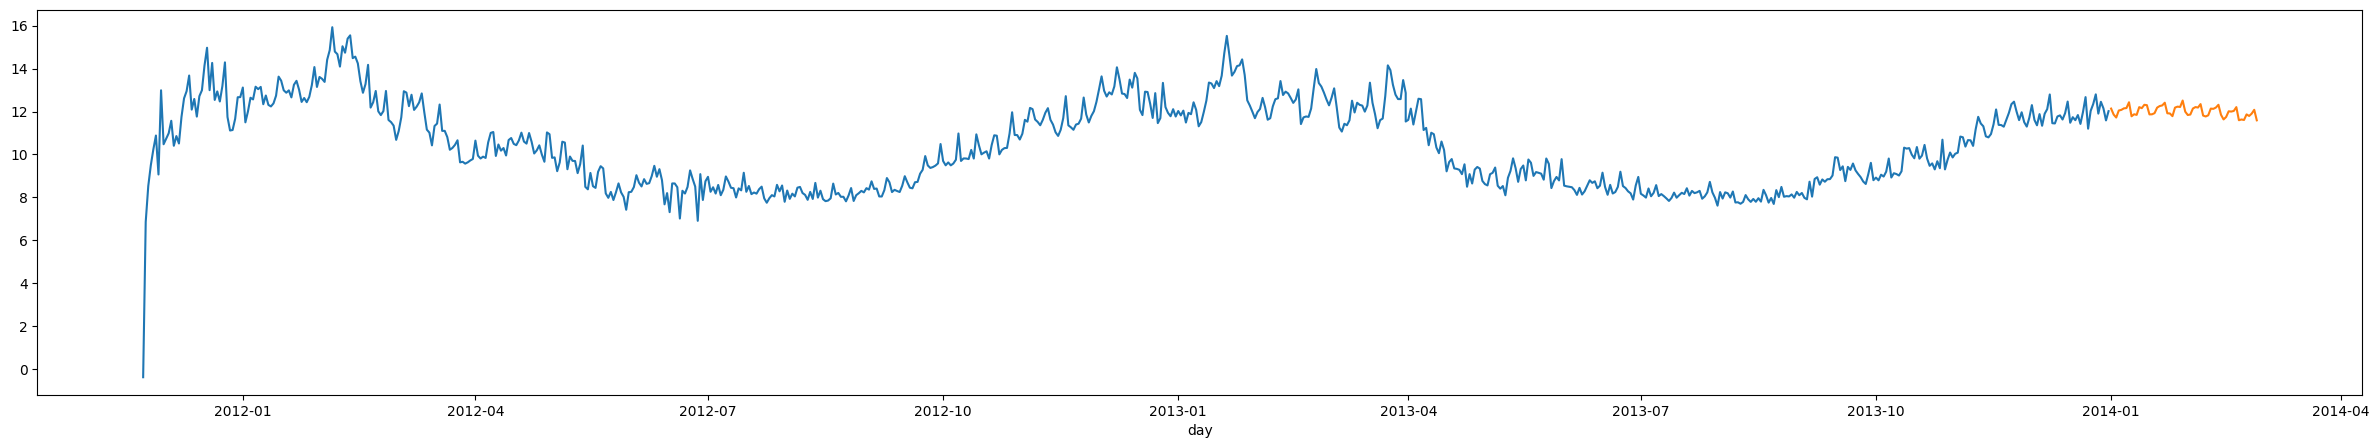

In [426]:
model_fit.fittedvalues.plot(figsize = (30,5))
test.predicted.plot()

In [427]:
test['predicted'].tail(5)

,predicted
day,
2014-02-23,11.866862
2014-02-24,11.793457
2014-02-25,11.902071
2014-02-26,12.080692
2014-02-27,11.590944


### LSTM

Using lags of upto 7 days we are going to convert this into a supervised problem. I have taken the function to create lags from this [tutorial](http://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/) by Jason Brownlee. He has also applied the same to convert multivariate data to a supervised dataframe which he has in turn applied LSTM on.

In [352]:
np.random.seed(11)

dataframe = weather_energy.loc[:pd.to_datetime('2014-02-27').date(), 'avg_energy'].astype('float32')
dataset = dataframe.values

In [353]:
dataset

array([ 6.9526925,  8.53648  ,  9.499782 , 10.267707 , 10.850805 ,
        9.103382 ,  9.274873 ,  8.813513 ,  9.227707 , 10.14591  ,
       10.862155 , 12.351882 , 10.657492 , 11.774341 , 10.94898  ,
       11.60697  , 11.824055 , 12.714686 , 13.803264 , 11.997481 ,
       11.9923525, 12.42522  , 12.362262 , 13.416573 , 13.583354 ,
       14.809275 , 13.793674 , 12.745489 , 12.171455 , 11.864904 ,
       12.289651 , 13.095058 , 12.9598465, 11.116032 , 11.513135 ,
       11.812708 , 12.17798  , 12.445351 , 12.480613 , 12.521146 ,
       12.779672 , 12.768204 , 12.757026 , 12.877513 , 12.742517 ,
       12.7957735, 13.419912 , 12.472598 , 12.0006895, 12.001739 ,
       12.0840435, 12.544458 , 13.5474415, 14.074913 , 13.063148 ,
       13.299702 , 12.799092 , 12.303991 , 12.801625 , 12.794907 ,
       13.759471 , 12.641012 , 12.888806 , 12.575381 , 12.397039 ,
       12.488275 , 13.39787  , 14.163874 , 13.461316 , 13.915599 ,
       13.831827 , 14.389352 , 14.540033 , 15.178076 , 15.9644

In [354]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    df = pd.DataFrame(data)
    cols, names = [], []

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names.append(f'var1(t-{i})')

    for i in range(0, n_out):
        cols.append(df.shift(-i))
        names.append('var1(t)' if i == 0 else f'var1(t+{i})')

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [355]:
reframed = series_to_supervised(dataset, 7, 1)
reframed.head(3)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,6.952693,8.536480,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513
8,8.536480,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707
9,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707,10.145910


In [356]:
# align exog (drop first 7 rows due to lags)
reframed['temperatureMax'] = weather_energy['temperatureMax'].values[7:829]

In [357]:
# put y at the end (as you did)
reframed = reframed.reindex(
    ['temperatureMax',
     'var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)',
     'var1(t)'],
    axis=1
).values

In [428]:
reframed

array([[11.87      ,  6.95269251,  8.53647995, ...,  9.10338211,
         9.27487278,  8.8135128 ],
       [12.15      ,  8.53647995,  9.49978161, ...,  9.27487278,
         8.8135128 ,  9.22770691],
       [ 8.07      ,  9.49978161, 10.26770687, ...,  8.8135128 ,
         9.22770691, 10.14591026],
       ...,
       [11.43      , 10.97136784, 10.85424519, ..., 11.67375565,
        10.58623505, 10.4764986 ],
       [11.29      , 10.85424519, 10.75495243, ..., 10.58623505,
        10.4764986 , 10.37536526],
       [10.31      , 10.75495243, 10.68823433, ..., 10.4764986 ,
        10.37536526, 10.53725052]])

**Normalization**

In [429]:
# split first, then scale (NO leakage)
n_test = 59
train = reframed[:-n_test, :]
test  = reframed[-n_test:-1, :]

scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
test  = scaler.transform(test)

In [431]:
train

array([[0.36752927, 0.        , 0.16610246, ..., 0.2297456 , 0.24899796,
        0.19720349],
       [0.37615527, 0.17574711, 0.2742473 , ..., 0.24899796, 0.19720349,
        0.2437029 ],
       [0.25046211, 0.28264117, 0.36045826, ..., 0.19720349, 0.2437029 ,
        0.34678479],
       ...,
       [0.24245225, 0.59754412, 0.57015033, ..., 0.54219527, 0.54029606,
        0.50827161],
       [0.23475046, 0.57512187, 0.58302832, ..., 0.54029606, 0.50827161,
        0.57574079],
       [0.31669747, 0.58785091, 0.57681271, ..., 0.50827161, 0.57574079,
        0.55618811]])

In [432]:
test

array([[0.32101047, 0.58170719, 0.64517652, 0.54219527, 0.54029606,
        0.50827161, 0.57574079, 0.55618811, 0.56694794],
       [0.32701787, 0.64928032, 0.54219527, 0.54029606, 0.50827161,
        0.57574079, 0.55618811, 0.56694794, 0.52789644],
       [0.33302526, 0.54749013, 0.54029606, 0.50827161, 0.57574079,
        0.55618811, 0.56694794, 0.52789644, 0.48884495],
       [0.3250154 , 0.54561288, 0.50827161, 0.57574079, 0.55618811,
        0.56694794, 0.52789644, 0.48884495, 0.51797996],
       [0.2969809 , 0.51395881, 0.57574079, 0.55618811, 0.56694794,
        0.52789644, 0.48884495, 0.51797996, 0.57955826],
       [0.37030191, 0.58064767, 0.55618811, 0.56694794, 0.52789644,
        0.48884495, 0.51797996, 0.57955826, 0.64910674],
       [0.38909427, 0.56132113, 0.56694794, 0.52789644, 0.48884495,
        0.51797996, 0.57955826, 0.64910674, 0.5113982 ],
       [0.35243376, 0.57195651, 0.52789644, 0.48884495, 0.51797996,
        0.57955826, 0.64910674, 0.5113982 , 0.49602188],


In [433]:
# split into train and test sets
train_X, train_y = train[:, :-1], train[:, -1]
test_X,  test_y  = test[:, :-1],  test[:, -1]

In [434]:
# timesteps=1 (your current approach)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X  = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

**Modelling**

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 4s - 407ms/step - loss: 0.1002
Epoch 2/50
11/11 - 0s - 23ms/step - loss: 0.0459
Epoch 3/50
11/11 - 0s - 27ms/step - loss: 0.0192
Epoch 4/50
11/11 - 0s - 27ms/step - loss: 0.0113
Epoch 5/50
11/11 - 0s - 29ms/step - loss: 0.0097
Epoch 6/50
11/11 - 0s - 15ms/step - loss: 0.0082
Epoch 7/50
11/11 - 0s - 11ms/step - loss: 0.0068
Epoch 8/50
11/11 - 0s - 14ms/step - loss: 0.0059
Epoch 9/50
11/11 - 0s - 18ms/step - loss: 0.0053
Epoch 10/50
11/11 - 0s - 22ms/step - loss: 0.0047
Epoch 11/50
11/11 - 0s - 12ms/step - loss: 0.0043
Epoch 12/50
11/11 - 0s - 13ms/step - loss: 0.0040
Epoch 13/50
11/11 - 0s - 13ms/step - loss: 0.0038
Epoch 14/50
11/11 - 0s - 18ms/step - loss: 0.0037
Epoch 15/50
11/11 - 0s - 22ms/step - loss: 0.0036
Epoch 16/50
11/11 - 0s - 15ms/step - loss: 0.0035
Epoch 17/50
11/11 - 0s - 16ms/step - loss: 0.0035
Epoch 18/50
11/11 - 0s - 17ms/step - loss: 0.0035
Epoch 19/50
11/11 - 0s - 22ms/step - loss: 0.0034
Epoch 20/50
11/11 - 0s - 29ms/step - loss: 0.0034
Epoch 21/50
11/11 -

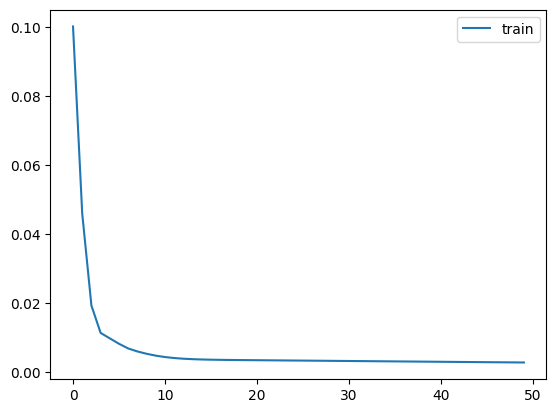

In [439]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

In [440]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 50)             │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,555 (138.89 KB)

 Trainable params: 11,851 (46.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,704 (92.60 KB)

**Prediction**

In [363]:
# predict
yhat = model.predict(test_X)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


In [364]:
# inverse scaling (IMPORTANT: order must be [X..., y])
test_X_2d = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = scaler.inverse_transform(np.concatenate((test_X_2d, yhat), axis=1))
inv_y    = scaler.inverse_transform(np.concatenate((test_X_2d, test_y.reshape(-1,1)), axis=1))


In [365]:

pred = inv_yhat[:, -1]
act  = inv_y[:, -1]

In [366]:
rmse = math.sqrt(mean_squared_error(act, pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.441


**Performance**

In [368]:
act = [i[8] for i in inv_y] # last element is the predicted average energy
pred = [i[8] for i in inv_yhat] # last element is the actual average energy

# calculate RMSE
import math
rmse = math.sqrt(mean_squared_error(act, pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.441


In [369]:
rmse_pct = rmse / weather_energy['avg_energy'].mean() * 100
print(f"RMSE as % of mean: {rmse_pct:.2f}%")


RMSE as % of mean: 4.20%


In [370]:
n_test = 30
y_test = weather_energy['avg_energy'].iloc[-n_test:].reset_index(drop=True)

naive_pred = y_test.shift(1).dropna()
rmse_naive = np.sqrt(mean_squared_error(y_test.iloc[1:], naive_pred))

print("Naive RMSE:", rmse_naive)

Naive RMSE: 1.9692965415414863


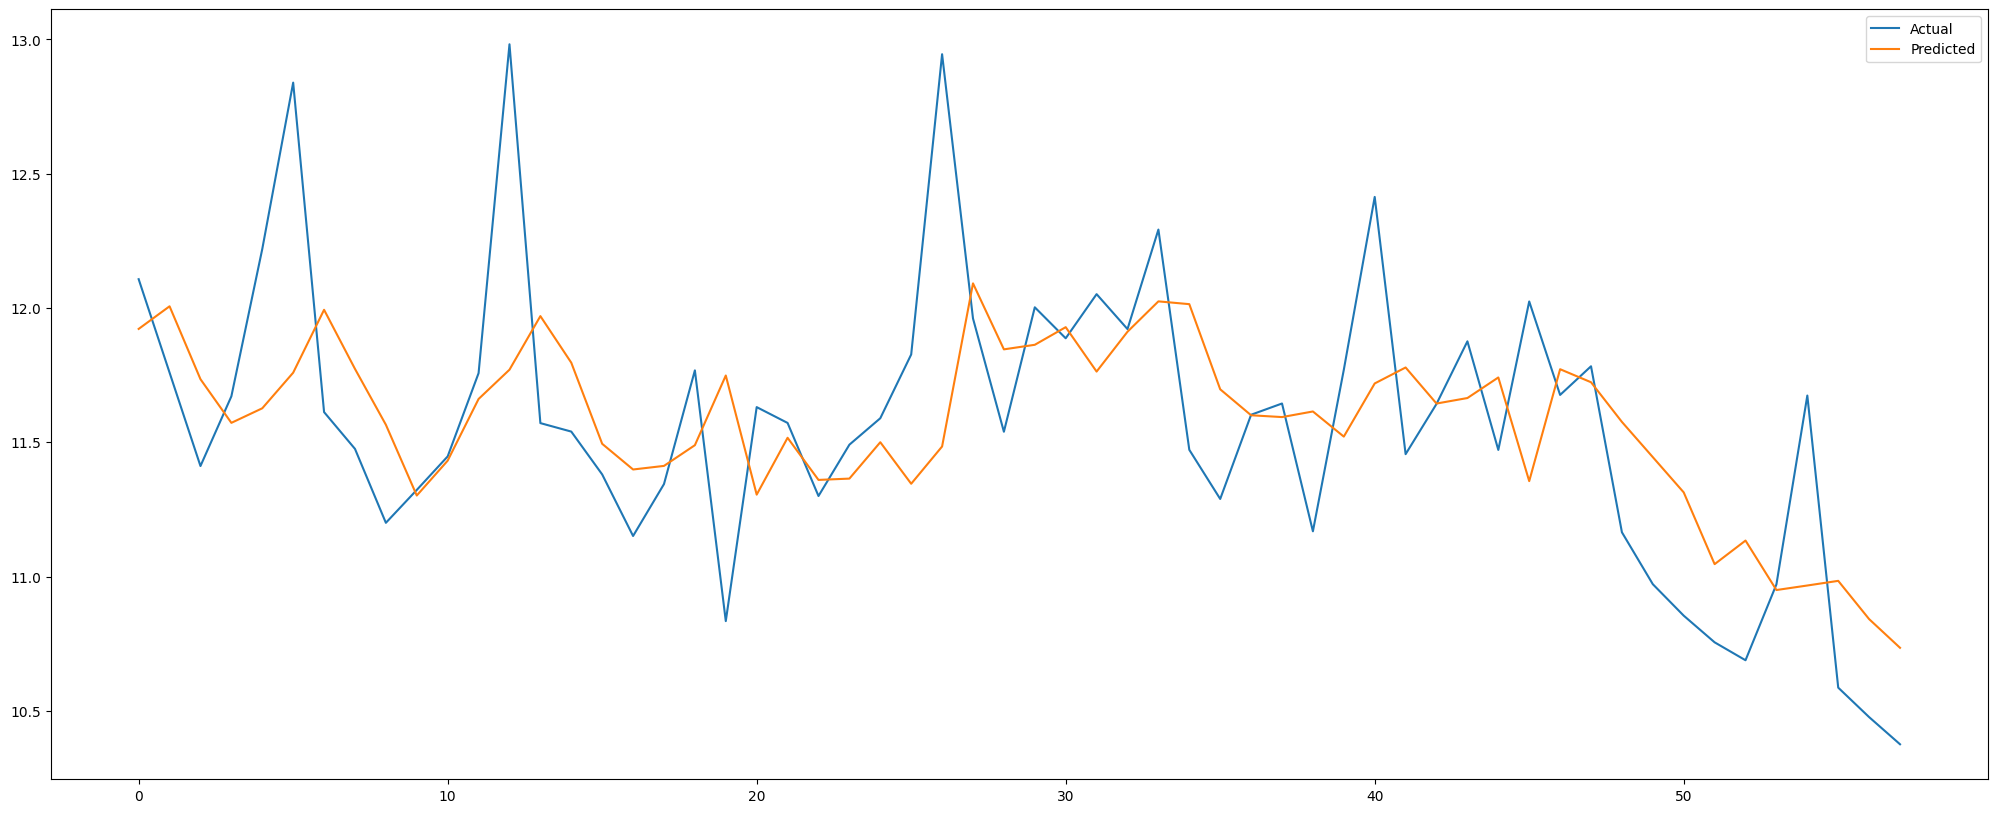

In [371]:
predicted_lstm = pd.DataFrame({'predicted': pred, 'avg_energy': act})
plt.figure(figsize=(25,10))
plt.plot(predicted_lstm['avg_energy'], label='Actual')
plt.plot(predicted_lstm['predicted'], label='Predicted')
plt.legend()
plt.show()

#Hourly